# Playing around with Quasars

In [38]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import vstack

import collections
import numpy as np
import healpy as hp


Load the data

In [2]:
#NGC =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
#NGC_r =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
#SGC =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
#SGC_r =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_random-SGC-vDR16.fits')
NGC =  fits.open('/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
NGC_r =  fits.open('/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
SGC =  fits.open('/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
SGC_r =  fits.open('/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-SGC-vDR16.fits')



Information about data

In [3]:
NGC_hdu =  NGC.info()
NGC_r_hdu =  NGC_r.info()
SGC_hdu =  SGC.info()
SGC_r_hdu =  SGC_r.info()

Filename: /home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-NGC-vDR16.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     27   218209R x 9C   [D, D, D, D, D, D, D, D, K]   
Filename: /home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-NGC-vDR16.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     24   11099858R x 8C   [D, D, D, D, D, D, D, D]   
Filename: /home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-SGC-vDR16.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     27   125499R x 9C   [D, D, D, D, D, D, D, D, K]   
Filename: /home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-SGC-vDR16.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     

In [4]:
cols = NGC_r[1].columns
cols.info()

name:
    ['RA', 'DEC', 'Z', 'WEIGHT_FKP', 'WEIGHT_SYSTOT', 'WEIGHT_CP', 'WEIGHT_NOZ', 'NZ']
format:
    ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']
unit:
    ['', '', '', '', '', '', '', '']
null:
    ['', '', '', '', '', '', '', '']
bscale:
    ['', '', '', '', '', '', '', '']
bzero:
    ['', '', '', '', '', '', '', '']
disp:
    ['', '', '', '', '', '', '', '']
start:
    ['', '', '', '', '', '', '', '']
dim:
    ['', '', '', '', '', '', '', '']
coord_type:
    ['', '', '', '', '', '', '', '']
coord_unit:
    ['', '', '', '', '', '', '', '']
coord_ref_point:
    ['', '', '', '', '', '', '', '']
coord_ref_value:
    ['', '', '', '', '', '', '', '']
coord_inc:
    ['', '', '', '', '', '', '', '']
time_ref_pos:
    ['', '', '', '', '', '', '', '']


From fits to pandas and then to maps

In [29]:
NGC_table =   Table.read(NGC)
NGC_r_table =  Table.read(NGC_r)
SGC_table =   Table.read(SGC)
SGC_r_table = Table.read(SGC_r)

In [30]:
NGC_data = NGC_table.to_pandas()
NGC_r_data = NGC_r_table.to_pandas()
SGC_data = SGC_table.to_pandas()
SGC_r_data = SGC_r_table.to_pandas()

In [114]:
def make_map(field, random):
    nside = 512
    
    field_ra = np.radians(field['RA'].values) #Phi
    field_dec = np.radians(field['DEC'].values) #Pi/2 - dec = theta
    random_ra = np.radians(random['RA'].values) 
    random_dec = np.radians(random['DEC'].values) 
    
    field_FKP = np.array(field['WEIGHT_FKP'].values) 
    field_SYSTOT = np.array(field['WEIGHT_SYSTOT'].values) 
    field_CP = np.array(field['WEIGHT_CP'].values) 
    field_NOZ = np.array(field['WEIGHT_NOZ'].values)
    field_data = field_SYSTOT*field_CP*field_NOZ #FKP left out
    
    random_FKP = np.array(random['WEIGHT_FKP'].values) 
    random_SYSTOT = np.array(random['WEIGHT_SYSTOT'].values) 
    random_CP = np.array(random['WEIGHT_CP'].values) 
    random_NOZ = np.array(random['WEIGHT_NOZ'].values)
    random_data = random_SYSTOT*random_CP*random_NOZ
    
    field_indices = hp.ang2pix(nside, np.pi/2 - field_dec, field_ra) #pixel_indecis
    random_indices = hp.ang2pix(nside, np.pi/2 - random_dec, random_ra)  
    
    field_pixel_data = np.bincount(field_indices, field_data, hp.nside2npix(nside)) 
                                                                        #for each pixel in the resolution, 
                                                                        #Adds all the data entries that 
                                                                        #have been assigned the such pixel
    random_pixel_data = np.bincount(random_indices, random_data, hp.nside2npix(nside))
    
    alpha = sum(field_pixel_data)/sum(random_pixel_data)
    print(alpha)
    
    pixel_density_data = np.zeros(hp.nside2npix(nside))
    goodpix = random_pixel_data > 0   #avoid dividing by 0
    pixel_density_data[goodpix] = field_pixel_data[goodpix] / alpha*random_pixel_data[goodpix] - 1
    
    #pixel_density_data = field_pixel_data/(alpha*random_pixel_data) -1
    
    hp.mollview(pixel_density_data)


0.020099915899806933


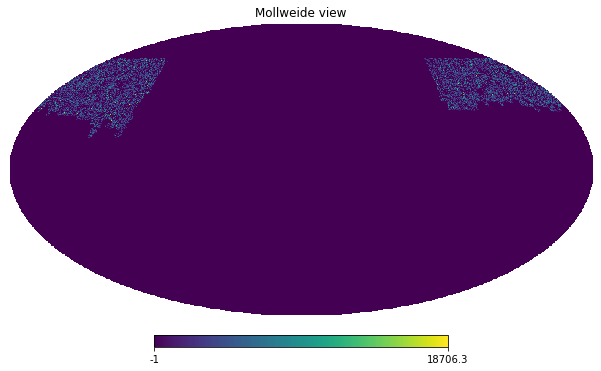

In [115]:
make_map(NGC_data, NGC_r_data)

0.017927095980433835


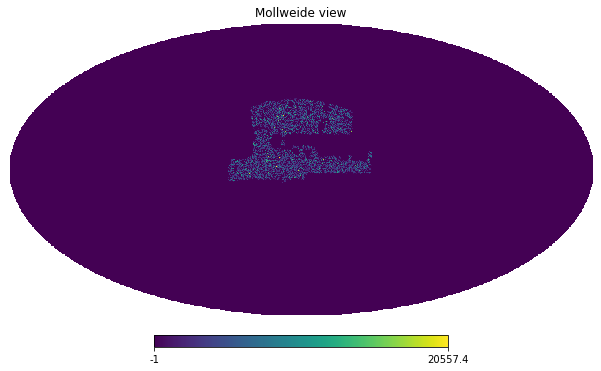

In [116]:
make_map(SGC_data, SGC_r_data)